In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load CSVs
path = './multi_surface_track_1_1'

# Linear
ackermann = pd.read_csv(f'{path}/ackermann.csv')
odomfil = pd.read_csv(f'{path}/odomfil.csv')

# Angular
imu = pd.read_csv(f'{path}/imu.csv')

# IDEK
stack_odom = pd.read_csv(f'{path}/odom_drift.csv')

# Linear

In [3]:
throttle_sorted = ackermann.sort_values(['sec', 'nanosec'], ignore_index=True)
odomfil_sorted = odomfil.sort_values(['sec', 'nanosec'], ignore_index=True)
stack_odom_sorted = stack_odom.sort_values(['sec', 'nanosec'], ignore_index=True)

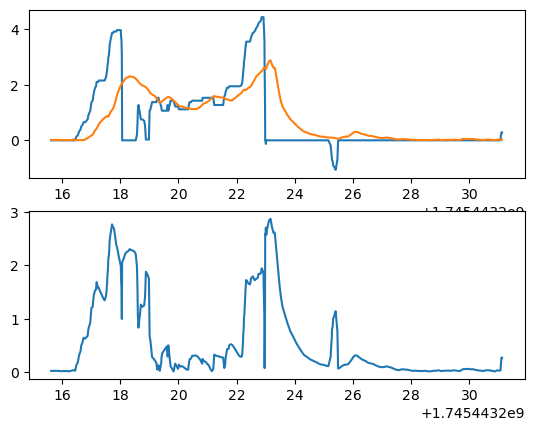

In [4]:
from sklearn.preprocessing import StandardScaler
from math import atan2, asin

# Scale throttle['speed'] and odom velocity
#scaler = StandardScaler()
#scaler.fit(throttle_sorted['speed'].values.reshape(-1, 1))
#throttle_scaled = scaler.transform(throttle_sorted['speed'].values.reshape(-1, 1)).squeeze(axis=-1)
throttle_scaled = throttle_sorted['speed'] 

# Combine x and y
odomfil_comb = np.sqrt((odomfil_sorted['twist_linear_y'] ** 2) + (odomfil_sorted['twist_linear_x'] ** 2))

#scaler.fit(odomfil_comb.values.reshape(-1, 1))
#odomfil_scaled = scaler.transform(odomfil_comb.values.reshape(-1, 1)).squeeze(axis=-1)
odomfil_scaled = odomfil_comb

# Resample to same length
odomfil_scaled = 2*np.interp((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), (odomfil_sorted['sec'] + odomfil_sorted['nanosec'] * 10**-9), odomfil_scaled)
odomfil_position_x = np.interp((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), (odomfil_sorted['sec'] + odomfil_sorted['nanosec'] * 10**-9), odomfil_sorted['position_x'])
odomfil_position_y = np.interp((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), (odomfil_sorted['sec'] + odomfil_sorted['nanosec'] * 10**-9), odomfil_sorted['position_y'])

fig, axs = plt.subplots(2)

axs[0].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), throttle_scaled)
axs[0].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), odomfil_scaled)
#axs[0].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), throttle_sorted['steering_angle'])

axs[1].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), abs(throttle_scaled - odomfil_scaled))


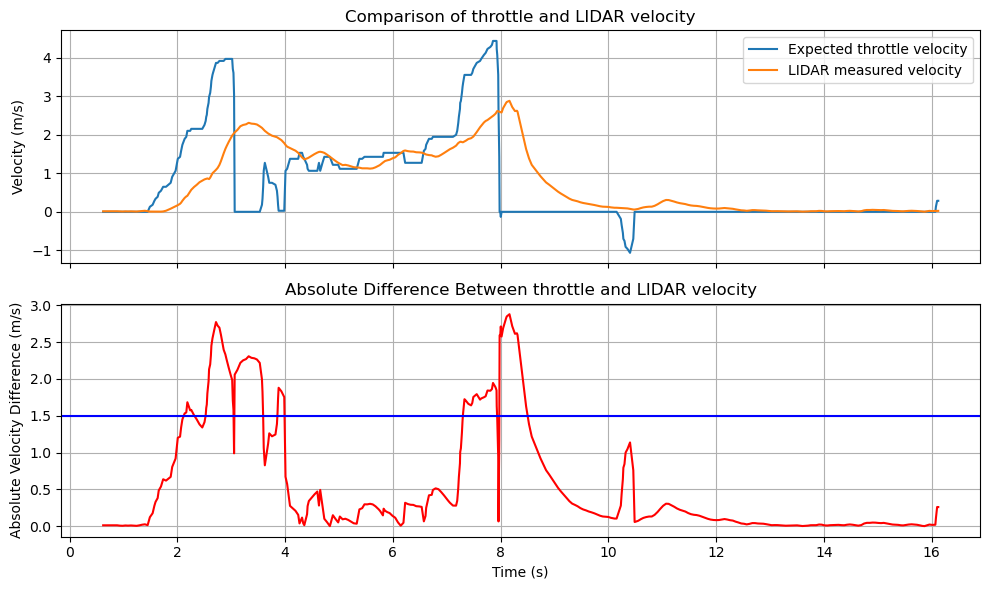

In [5]:
# Plot the difference
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))

time = throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9 - throttle_sorted['sec'][0]

# First plot: Throttle vs Odom data
axs[0].plot(time, throttle_scaled, label="Expected throttle velocity", linestyle='-')
axs[0].plot(time, odomfil_scaled, label="LIDAR measured velocity", linestyle='-')
axs[0].set_title("Comparison of throttle and LIDAR velocity")
axs[0].set_ylabel("Velocity (m/s)")
axs[0].legend()
axs[0].grid()

# Second plot: Absolute difference
axs[1].plot(time, abs(throttle_scaled - odomfil_scaled), color='r')
axs[1].set_ylabel("Absolute Velocity Difference (m/s)")
axs[1].set_title("Absolute Difference Between throttle and LIDAR velocity")
axs[1].set_xlabel("Time (s)")
axs[1].grid()
axs[1].axhline(1.5, color='blue')

plt.tight_layout()
plt.show()

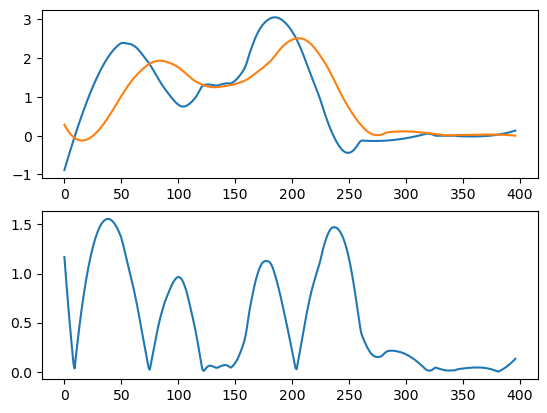

In [6]:
# Plot the difference (savgo bad)
from scipy.signal import savgol_filter

fig, axs = plt.subplots(2)

axs[0].plot(savgol_filter(throttle_scaled, 101, 3))
axs[0].plot(savgol_filter(odomfil_scaled, 101, 3))

axs[1].plot(np.abs(savgol_filter(throttle_scaled, 101, 3) - savgol_filter(odomfil_scaled, 101, 3)))

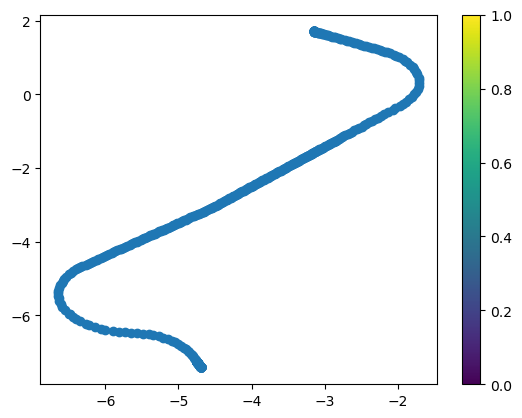

In [7]:
# Unfiltered car odom map
plt.scatter(stack_odom_sorted['position_x'], stack_odom_sorted['position_y'])
plt.colorbar()

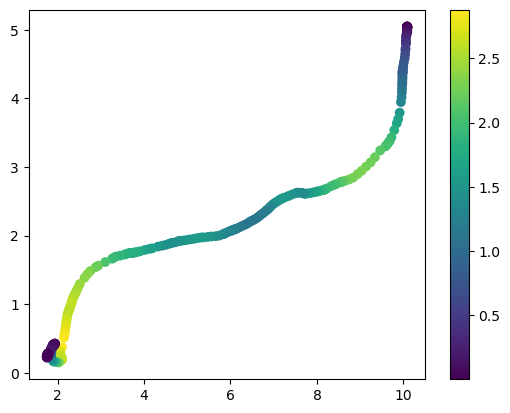

In [8]:
# Filtered car odom
plt.scatter(odomfil_position_x, odomfil_position_y, c=(odomfil_scaled))
plt.colorbar()

# Angular

In [9]:
wheelbase = 0.32
ackermann['angular_vel'] = ackermann['speed'] * (np.tan(ackermann['steering_angle']) / wheelbase)

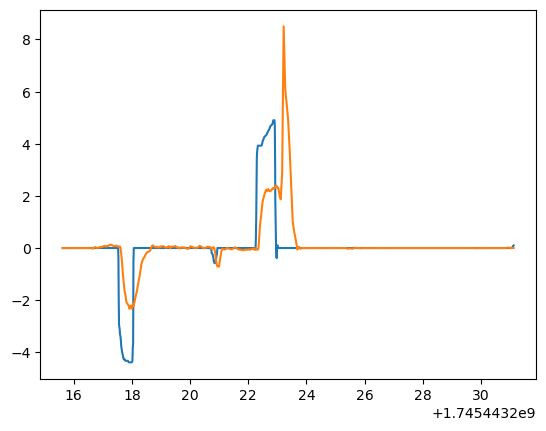

In [10]:
from sklearn.preprocessing import StandardScaler
from math import atan2, asin

imu_sorted = imu.sort_values(['sec', 'nanosec'], ignore_index=True)
ackermann_sorted = ackermann.sort_values(['sec', 'nanosec'], ignore_index=True)

# Resample to same length
imu_resampled = np.interp((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), (imu_sorted['sec'] + imu_sorted['nanosec'] * 10**-9), imu_sorted['twist_angular_z'])

plt.plot((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), ackermann_sorted['angular_vel'])
plt.plot((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), np.deg2rad(imu_resampled))

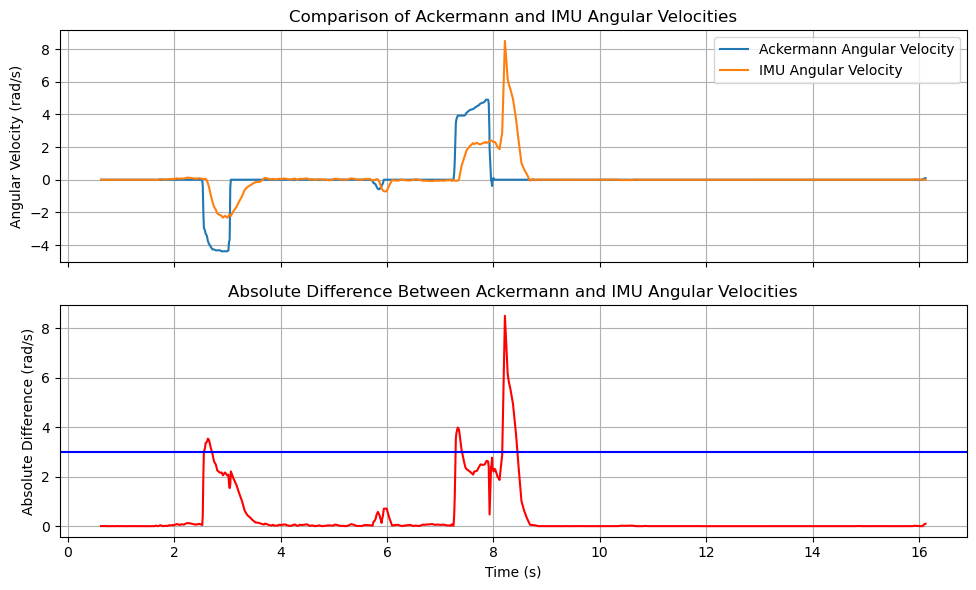

In [11]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))

# Compute time
time = ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9 - ackermann_sorted['sec'][0]
imu_rad = np.deg2rad(imu_resampled)  # Convert IMU data to radians per second

# First subplot: Ackermann vs. IMU angular velocity
axs[0].plot(time, ackermann_sorted['angular_vel'], label="Ackermann Angular Velocity", linestyle='-')
axs[0].plot(time, imu_rad, label="IMU Angular Velocity", linestyle='-')
axs[0].set_ylabel("Angular Velocity (rad/s)")
axs[0].legend()
axs[0].grid()
axs[0].set_title("Comparison of Ackermann and IMU Angular Velocities")

# Second subplot: Absolute difference
axs[1].plot(time, abs(ackermann_sorted['angular_vel'] - imu_rad), color='r', linestyle='-')
axs[1].set_ylabel("Absolute Difference (rad/s)")
axs[1].set_xlabel("Time (s)")
axs[1].grid()
axs[1].set_title("Absolute Difference Between Ackermann and IMU Angular Velocities")
axs[1].axhline(3, color='blue')

plt.tight_layout()
plt.show()

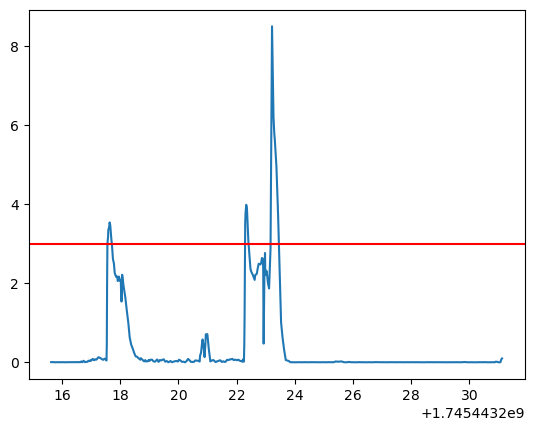

In [12]:
# Angular Velocity difference
angular_velocity_difference = ackermann_sorted['angular_vel'] - np.deg2rad(imu_resampled)
plt.plot((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), np.absolute(angular_velocity_difference))
plt.axhline(3, color='red')

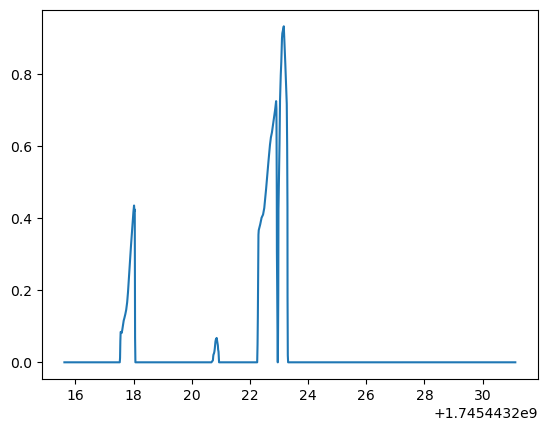

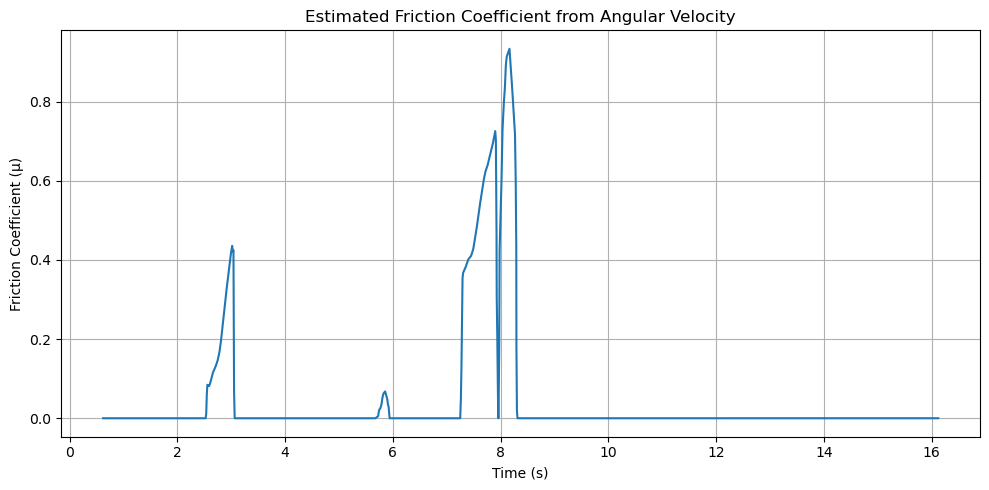

In [13]:
wheelbase = 0.32       # meters
track_width = 0.296    # meters
turning_radius = np.where(np.absolute(ackermann_sorted['steering_angle']) != 0, wheelbase / np.tan(np.absolute(ackermann_sorted['steering_angle'])), np.inf)
#plt.plot((ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9), turning_radius)
mu = odomfil_scaled**2/turning_radius/9.81
plt.plot(ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9, mu)
#plt.plot(ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9, np.absolute(angular_velocity_difference))


fig, ax = plt.subplots(figsize=(10, 5))

# Compute time
time = ackermann_sorted['sec'] + ackermann_sorted['nanosec'] * 10**-9 - ackermann_sorted['sec'][0]

# Plot data
ax.plot(time, mu, linestyle='-')

# Formatting
ax.set_xlabel("Time (s)")
ax.set_ylabel("Friction Coefficient (μ)")
ax.set_title("Estimated Friction Coefficient from Angular Velocity")
ax.grid()

plt.tight_layout()
plt.show()

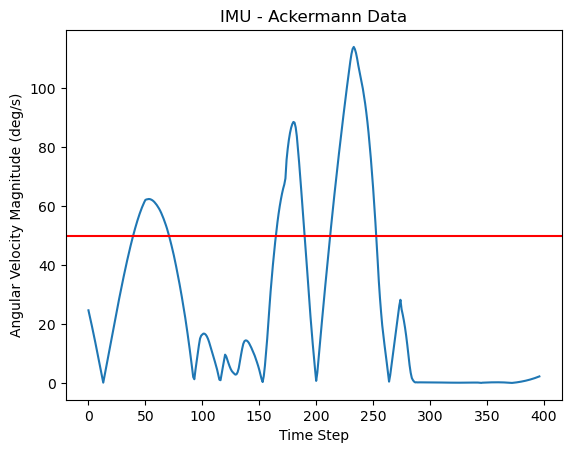

In [14]:
plt.plot(np.abs(savgol_filter(imu_resampled, 101, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 101, 3)))
plt.title('IMU - Ackermann Data')
plt.xlabel('Time Step')
plt.ylabel('Angular Velocity Magnitude (deg/s)')
plt.axhline(50, c='red')
plt.savefig('subtracted.pdf')

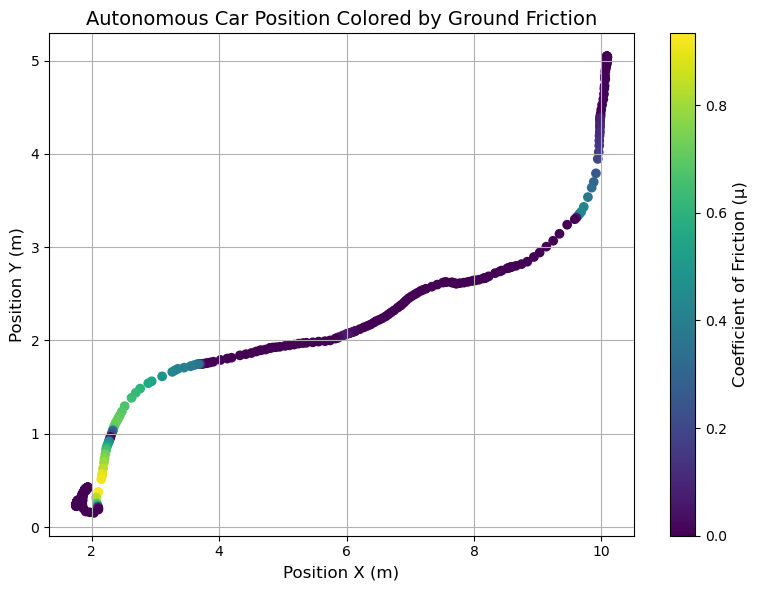

In [15]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(odomfil_position_x, odomfil_position_y, c=mu, cmap='viridis')
cbar = plt.colorbar(scatter)
cbar.set_label('Coefficient of Friction (μ)', fontsize=12)

plt.xlabel('Position X (m)', fontsize=12)
plt.ylabel('Position Y (m)', fontsize=12)
plt.title('Autonomous Car Position Colored by Ground Friction', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

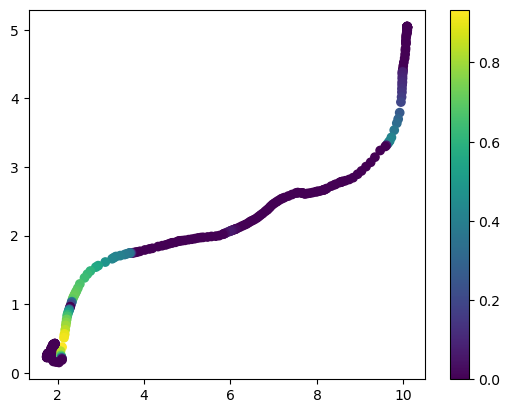

In [16]:
plt.scatter(odomfil_position_x, odomfil_position_y, c=mu)
plt.colorbar()

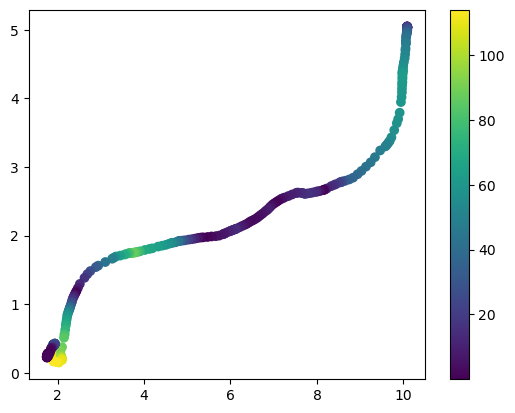

In [17]:
plt.scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(imu_resampled, 101, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 101, 3))))
plt.colorbar()

# Both

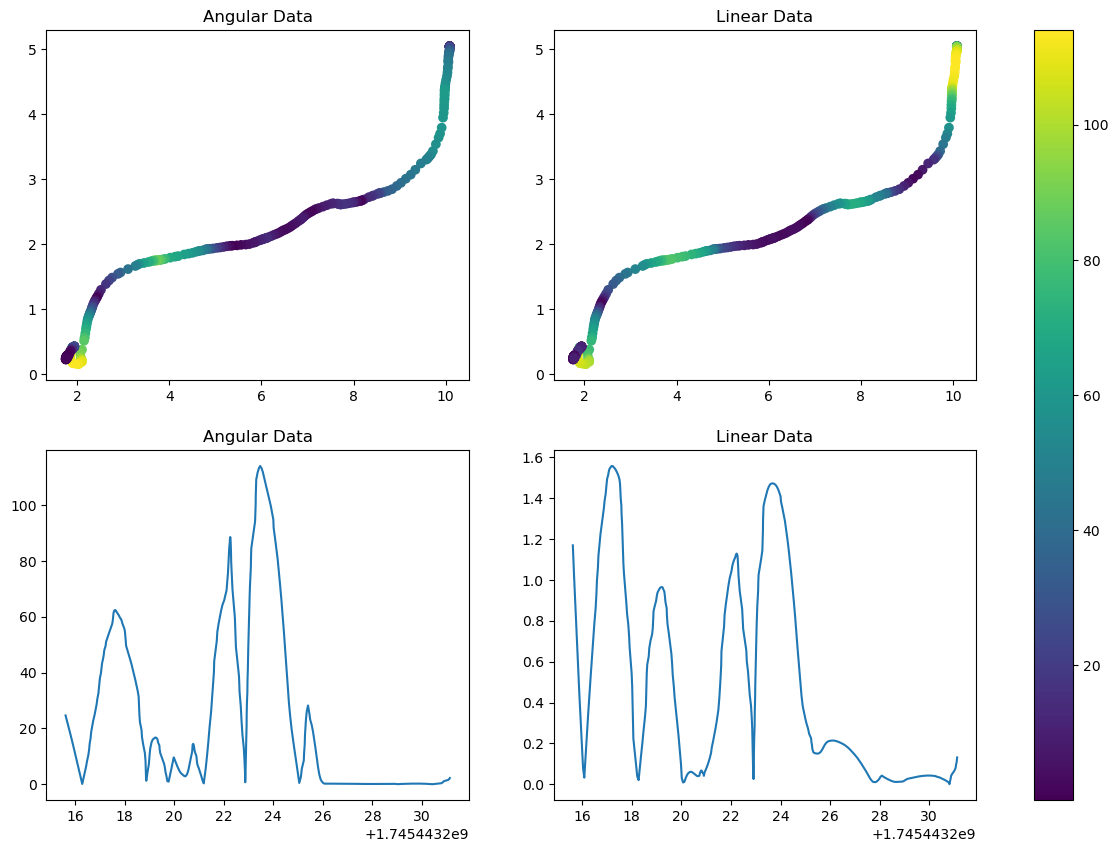

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(imu_resampled, 101, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 101, 3))))
axs[0, 0].set_title('Angular Data')

axs[0, 1].scatter(odomfil_position_x, odomfil_position_y, c=(np.abs(savgol_filter(throttle_scaled, 101, 3) - savgol_filter(odomfil_scaled, 101, 3))))
axs[0, 1].set_title('Linear Data')

axs[1, 0].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), np.abs(savgol_filter(imu_resampled, 101, 3) - savgol_filter(np.rad2deg(ackermann_sorted['angular_vel']), 101, 3)))
axs[1, 0].set_title('Angular Data')

axs[1, 1].plot((throttle_sorted['sec'] + throttle_sorted['nanosec'] * 10**-9), np.abs(savgol_filter(throttle_scaled, 101, 3) - savgol_filter(odomfil_scaled, 101, 3)))
axs[1, 1].set_title('Linear Data')

fig.colorbar(axs[0, 0].collections[0], ax=axs, orientation='vertical')